# Trends in circulation patterns and relative hot extreme for the 3 regions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import proplot as pplot
import cmaps
import xarray as xr
from scipy.stats import linregress
from warnings import simplefilter
import scikits.bootstrap as bootstraps
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
domain_lonlat = {
    'EAS':{'lon_min':90,'lon_max':130,'lat_min':30,'lat_max':60},
    'EU':{'lon_min':10,'lon_max':50,'lat_min':35,'lat_max':65},
    'WNA':{'lon_min':220,'lon_max':260,'lat_min':25,'lat_max':55},
}
fig_dir = '/Users/zeqinhuang/Documents/paper/HWdna/figure_res/'

In [3]:
def get_domain_patt(domain,patt):
    som_patt_weights = pd.read_csv('/Users/zeqinhuang/Documents/paper/HWdna/procData/som_pattern_reanalyses_avg_weights_' + domain + '.csv', index_col=0)
    patt_weight = som_patt_weights['grid:'+str(patt)+'-0']
    return patt_weight

def get_winner_respect_to_reanalyses_avg(domain,forcing):
    if forcing == 'historical':
        work_dir = '/Users/zeqinhuang/Documents/paper/HWdna/procData/som_winner_relative_to_reanalyses_mean_historical_' + domain + '.csv'
    else:
        work_dir = '/Users/zeqinhuang/Documents/paper/HWdna/procData/som_winner_forings_relative_to_reanalyses_mean_' + forcing + '_' + domain + '.csv'
    winner = pd.read_csv(work_dir,index_col=0)
    return winner

## get pattern occurrence
def count_occur(winner_df,target_patt): 
    years = [i[:4] for i in winner_df.index]
    winner_df['year'] = years
    winner_patt_count_1 = pd.DataFrame()
    winner_patt_count_2 = pd.DataFrame()
    winner_patt_count_3 = pd.DataFrame()
    winner_patt_count_4 = pd.DataFrame()
    for c in winner_df.columns[:-1]:
        winner_c_df = winner_df[['year',c]]
        winner_patt_count_1[c] = winner_c_df[c].eq(0).groupby(winner_c_df.year).sum()
        winner_patt_count_2[c] = winner_c_df[c].eq(1).groupby(winner_c_df.year).sum()
        winner_patt_count_3[c] = winner_c_df[c].eq(2).groupby(winner_c_df.year).sum()
        winner_patt_count_4[c] = winner_c_df[c].eq(3).groupby(winner_c_df.year).sum()
    if target_patt == 0:
        winner_patt_count = winner_patt_count_1
    elif target_patt == 1:
        winner_patt_count = winner_patt_count_2
    elif target_patt == 2:
        winner_patt_count = winner_patt_count_3
    else:
        winner_patt_count = winner_patt_count_4
    return winner_patt_count

## get pattern persistence, pattern persistence is defined as the average duration of a typical pattern in a year
def pattern_persist_cal(listrand,target_patt): ## target_patt must be on of [0,1,2,3]
    count=1
    consec_list = []
    patt_list = []
    for i in range(len(listrand[:-1])):
        if listrand[i] == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            patt_list.append(listrand[i])
            count=1
    consec_list.append(count)        ## consec_list is a list of the consecutive pattern of the listrand
    patt_list.append(listrand[i+1])  ## patt_list is a list of pattern correspond to consec_list
    patt_consec = pd.DataFrame(list(zip(patt_list,consec_list)),columns=['patt','cons'])
    persist = patt_consec['cons'][patt_consec['patt']==target_patt]
    persist = persist.mean()
    return persist

## get pattern maximum duration
def pattern_maximum_duration_cal(listrand,target_patt): ## target_patt must be on of [0,1,2,3]
    count=1
    consec_list = []
    patt_list = []
    for i in range(len(listrand[:-1])):
        if listrand[i] == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            patt_list.append(listrand[i])
            count=1
    consec_list.append(count)        ## consec_list is a list of the consecutive pattern of the listrand
    patt_list.append(listrand[i+1])  ## patt_list is a list of pattern correspond to consec_list
    patt_consec = pd.DataFrame(list(zip(patt_list,consec_list)),columns=['patt','cons'])
    persist = patt_consec['cons'][patt_consec['patt']==target_patt]
    duration = persist.max()
    return duration

def get_forcing_ens_envelope(var_ano_df,quantile):
    var_historical_ano_quantile = var_ano_df.quantile(quantile,axis=1,numeric_only=True)
    return var_historical_ano_quantile

def get_bootstrap_ci(var_df,highlow,alpha=0.05,n_samples=10000):
    if highlow == 'high':
        border = var_df.apply(lambda x:bootstraps.ci(data=x[~np.isnan(x)],alpha=alpha,n_samples=n_samples)[1],axis=1)
    else:
        border = var_df.apply(lambda x:bootstraps.ci(data=x[~np.isnan(x)],alpha=alpha,n_samples=n_samples)[0],axis=1)
    return border

def count_nums_of_total_sig(var_df,pos_neg):
    # total = len(var_df.columns)
    trends = var_df.agg(lambda x: _compute_slope(x),axis=0)
    sig = var_df.agg(lambda x: _compute_sig(x),axis=0)
    if pos_neg == 'positive':
        trends_judge = trends > 0 * 1
        sig_judge = sig < 0.05 * 1
        similar_trend_sig = trends_judge * sig_judge
    else:
        trends_judge = trends < 0 * 1
        sig_judge = sig < 0.05 * 1
        similar_trend_sig = trends_judge * sig_judge
    similar_trend_sig_num = similar_trend_sig.sum()
    return similar_trend_sig_num

def count_nums_of_same_sign(var_df,pos_neg):
    trends = var_df.agg(lambda x: _compute_slope(x),axis=0)
    if pos_neg == 'positive':
        trends_judge = trends > 0 * 1
    else:
        trends_judge = trends < 0 * 1
    same_sign_num = trends_judge.sum(skipna=True)
    return same_sign_num

def get_hot_extreme_per_pattern(domain,pattern,forcing): ## pattern must be one of [0,1,2,3]
    path = '/Users/zeqinhuang/Documents/paper/HWdna/procData/hot_extreme_occur_trend_sig/hot_extreme_per_pattern_occur_patt' + str(pattern+1) + '_variation_' + forcing + '_' + domain +'.csv'
    hot_extreme_per_pattern = pd.read_csv(path,index_col=0)
    return hot_extreme_per_pattern

In [4]:
def get_hot_extreme_cmip_avg(domain,pattern,forcing,trendOrSig = 'trend'): ## pattern must be one of [0,1,2,3]
    path = '/Users/zeqinhuang/Documents/paper/HWdna/procData/hot_extreme_occur_trend_sig/hot_extreme_patt' + str(pattern+1) + '_occur_' + trendOrSig + '_'+ forcing + '_' + domain + '.nc'
    hot_extreme_occur_cmip_trend = xr.open_dataarray(path)
    hot_extreme_occur_cmip_trend_mean = hot_extreme_occur_cmip_trend.mean(dim='Dataset_run')
    return hot_extreme_occur_cmip_trend_mean
# 
def get_hot_extreme_cmip_sig(domain,pattern,forcing):
    hot_extreme_occur_cmip_mean = get_hot_extreme_cmip_avg(domain=domain,pattern=pattern,forcing=forcing,trendOrSig='trend')
    path = '/Users/zeqinhuang/Documents/paper/HWdna/procData/hot_extreme_occur_trend_sig/hot_extreme_patt' + str(pattern+1) + '_occur_' + 'trend' + '_'+ forcing + '_' + domain + '.nc'
    hot_extreme_occur_cmip_trend = xr.open_dataarray(path)
    cmip_num = len(hot_extreme_occur_cmip_trend['Dataset_run'])
    hot_extreme_occur_cmip_sig_pos = (hot_extreme_occur_cmip_mean > 0) * (hot_extreme_occur_cmip_trend > 0)
    hot_extreme_occur_cmip_sig_neg = (hot_extreme_occur_cmip_mean < 0) * (hot_extreme_occur_cmip_trend < 0)
    hot_extreme_occur_cmip_sig_pos_num = hot_extreme_occur_cmip_sig_pos.sum(dim='Dataset_run')
    hot_extreme_occur_cmip_sig_neg_num = hot_extreme_occur_cmip_sig_neg.sum(dim='Dataset_run')
    pos_sig = hot_extreme_occur_cmip_sig_pos_num > cmip_num * 0.8
    neg_sig = hot_extreme_occur_cmip_sig_neg_num > cmip_num * 0.8
    sig = pos_sig * 1 + neg_sig * 1
    return sig


In [6]:
def _compute_slope(var):
    mask_var = var[~np.isnan(var)]
    slp = linregress(range(len(mask_var)),mask_var).slope
    return slp

def _compute_sig(var):
    mask_var = var[~np.isnan(var)]
    sig = linregress(range(len(mask_var)),mask_var).pvalue
    return sig

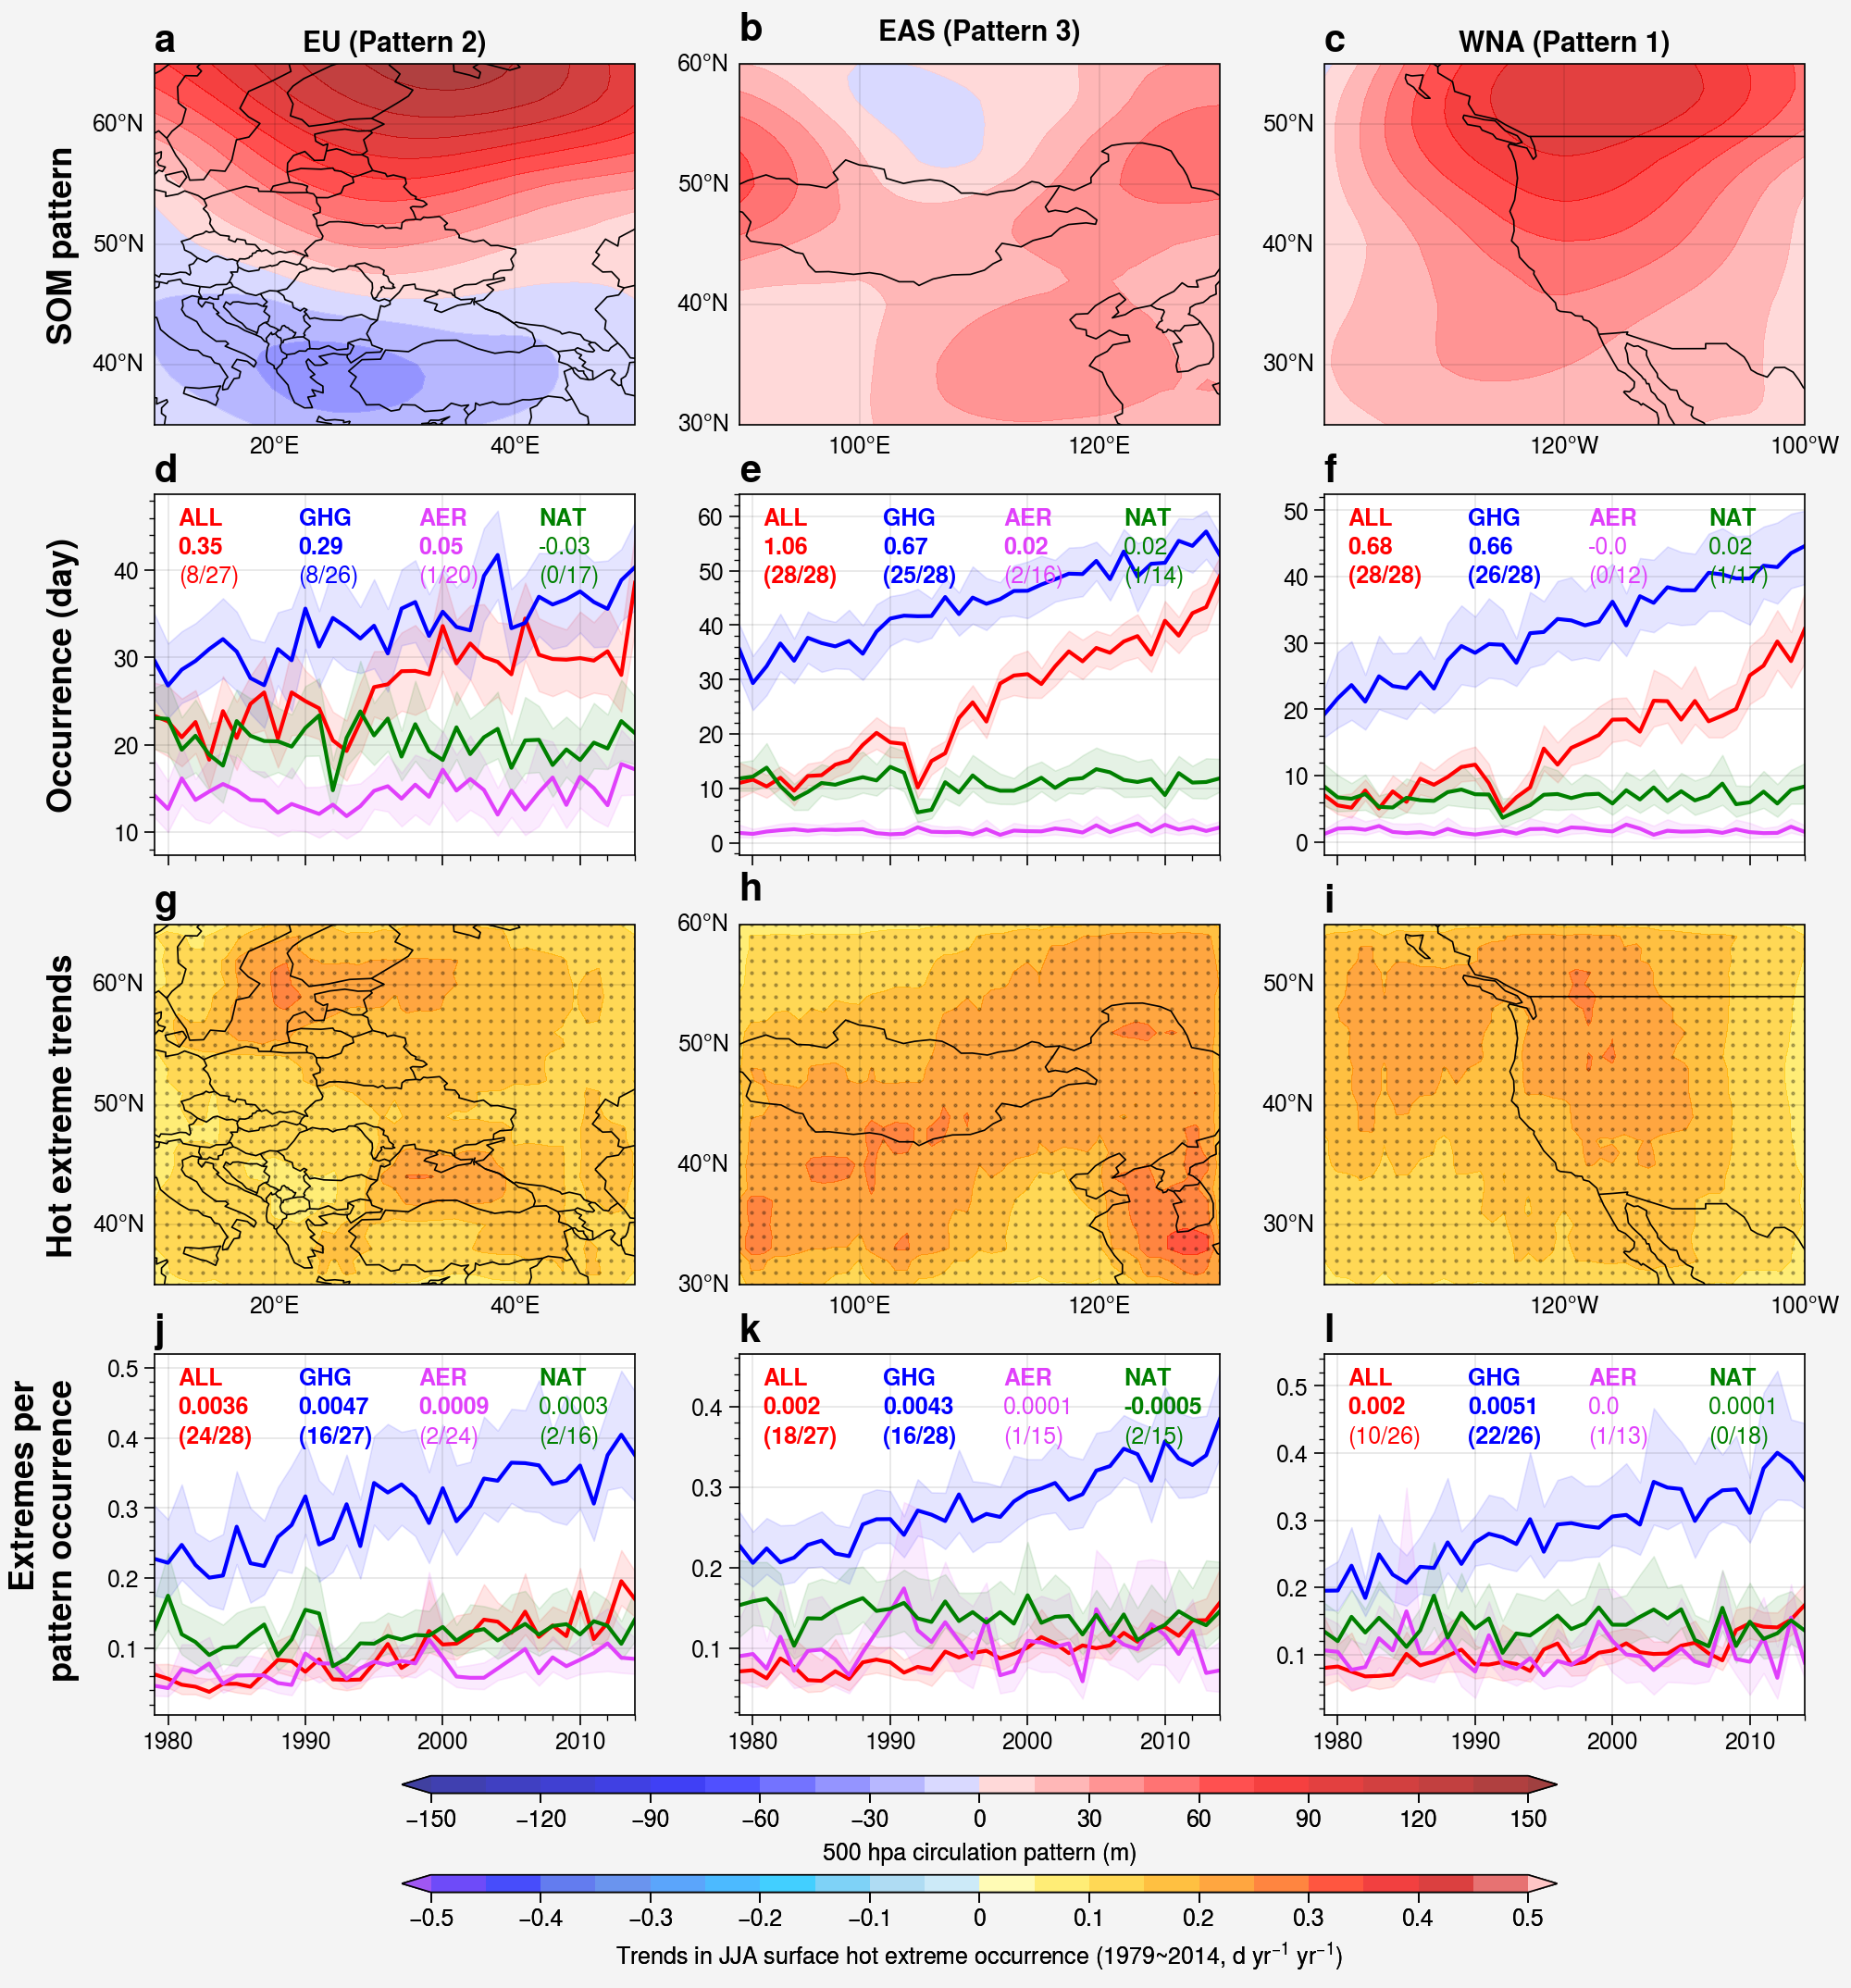

In [8]:
pplot.rc['leftlabel.size'] = 13
proj = pplot.Proj('pcarree', lon_0=180)
n_grid = 3 # 4 grids
m_row = 4 # 4 rows
regions = ['EU','EAS','WNA']
domain = regions[0]

fig, ax = pplot.subplots(
    ncols = n_grid, nrows = m_row,wspace=(4.5,4.5),hspace=(3,3,3),sharey=False,sharex=True,
    proj={1:'pcarree',2:'pcarree',3:'pcarree',7:'pcarree',8:'pcarree',9:'pcarree'},width = 10)
levels = [-150 + 15 * i for i in range(21)]
cmap1 = cmaps.BlRe

## first row for reanalyses-average patterns
for i in range(len(regions)):
    if i == 0:
        patt = 1
        domain = regions[i]
    elif i == 1:
        patt = 2
        domain = regions[i]
    else:
        patt = 0
        domain = regions[i]

    lon = np.arange(domain_lonlat[domain]['lon_min'],domain_lonlat[domain]['lon_max']+1,1)
    lat = np.arange(domain_lonlat[domain]['lat_min'],domain_lonlat[domain]['lat_max']+1,1)
    patt_weight = get_domain_patt(domain=domain,patt=patt)
    som_mn = np.reshape(patt_weight.to_list(),newshape=(len(lat),len(lon)),order='F')
    p1 = ax[0,i].contourf(lon,lat,som_mn,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1)
    if i != 0:
        ax[0,i].format(lonlim=(lon[0],lon[-1]+0.01), latlim=(lat[0]-0.01,lat[-1]+0.01),
                        coast=True, borders=True, latlabels=True, lonlabels=True, lonlines=20, latlines=10)
    else:
        ax[0,i].format(lonlim=(lon[0]-0.01,lon[-1]+0.01), latlim=(lat[0]-0.01,lat[-1]+0.01),
                        coast=True, borders=True, latlabels=True, lonlabels=True, lonlines=20, latlines=10)

## second row for pattern occurrence under different external forcings
forcings = ['historical','hist-GHG','hist-aer','hist-nat']
forcings_colors = ['red', 'blue', '#E040FB','green']
for i in range(len(regions)):
    if i == 0:
        patt = 1
        domain = regions[i]
    elif i == 1:
        patt = 2
        domain = regions[i]
    else:
        patt = 0
        domain = regions[i]

    for f in forcings:
        winner = get_winner_respect_to_reanalyses_avg(domain=domain,forcing=f)
        winner_f = winner.copy()
        winners_year = count_occur(winner_f,target_patt=patt)
        if f == 'historical':
            winner_era5 = winners_year['era5']
            winner_ncep2 = winners_year['ncep2']
            winners_jra55 = winners_year['jra55']
            winners_cmip6 = winners_year[winners_year.columns.difference(['era5','jra55','ncep2'])]
        else:
            winners_cmip6 = winners_year
        winners_cmip6_005 = get_bootstrap_ci(var_df=winners_cmip6,highlow='low',n_samples=1000)
        winners_cmip6_095 = get_bootstrap_ci(var_df=winners_cmip6,highlow='high',n_samples=1000)
        if f == 'historical':
            l1_hist = ax[1,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[0],alpha=0.1)
            l2_hist = ax[1,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[0])
            ax[1,i].text(0.05,0.9,s='ALL',horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.05,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.05,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[0])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[1,i].text(
                    0.05,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            else:
                ax[1,i].text(
                    0.05,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[0])
        elif f == 'hist-GHG':
            l1_ghg = ax[1,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[1],alpha=0.1)
            l2_ghg = ax[1,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[1])
            ax[1,i].text(0.30,0.9,s='GHG',horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.30,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.30,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[1])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[1,i].text(
                    0.30,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            else:
                ax[1,i].text(
                    0.30,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[1])
        elif f == 'hist-aer':
            l1_aer = ax[1,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[2],alpha=0.1)
            l2_aer = ax[1,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[2])
            ax[1,i].text(0.55,0.9,s='AER',horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.55,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.55,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[2])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[1,i].text(
                    0.55,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            else:
                ax[1,i].text(
                    0.55,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[2])
        else:
            l1_nat = ax[1,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[3],alpha=0.1)
            l2_nat = ax[1,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[3])
            ax[1,i].text(0.80,0.9,s='NAT',horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.80,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),2)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[1,i].text(0.80,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[3])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[1,i].text(
                    0.80,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            else:
                ax[1,i].text(
                    0.80,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[1,i].transAxes,fontsize=9,c = forcings_colors[3])
    ax[1,i].yaxis.label.set_visible(False)   
    ax[1,i].set_xlim([1979,2014])


## Fifth row for hot extreme occurrence trends under ALL forcing
levels_hot = [-0.5 + 0.05 * i for i in range(21)]
for i in range(len(regions)):
    if i == 0:
        patt = 1
        domain = regions[i]
    elif i == 1:
        patt = 2
        domain = regions[i]
    else:
        patt = 0
        domain = regions[i]

    lon = np.arange(domain_lonlat[domain]['lon_min'],domain_lonlat[domain]['lon_max']+1,1)
    lat = np.arange(domain_lonlat[domain]['lat_min'],domain_lonlat[domain]['lat_max']+1,1)
    hot_extreme_occur_trend = get_hot_extreme_cmip_avg(domain=domain,pattern=patt,forcing='historical',trendOrSig='trend')
    hot_extreme_occur_sig = get_hot_extreme_cmip_sig(domain=domain,pattern=patt,forcing='historical')

    X2,Y2 = np.meshgrid(lon,lat)
    X2 = X2 * hot_extreme_occur_sig
    Y2 = Y2 * hot_extreme_occur_sig

    p2 = ax[2,i].contourf(lon,lat,hot_extreme_occur_trend,levels = levels_hot, alpha=0.75, extend = 'both',cmap=cmaps.ncl_default)
    ax[2,i].scatter(X2,Y2,s=1,c='black',alpha=0.25)
    if i != 0:
        ax[2,i].format(lonlim=(lon[0],lon[-1]+0.01), latlim=(lat[0]-0.01,lat[-1]+0.01),
                        coast=True, borders=True, latlabels=True, lonlabels=True, lonlines=20, latlines=10)
    else:
        ax[2,i].format(lonlim=(lon[0],lon[-1]+0.01), latlim=(lat[0]-0.01,lat[-1]+0.01),
                        coast=True, borders=True, latlabels=True, lonlabels=True, lonlines=20, latlines=10)

## sixth row for the varations of hot extreme per pattern occurrence under different external forcing
forcings = ['historical','hist-GHG','hist-aer','hist-nat']
forcings_colors = ['red', 'blue', '#E040FB','green']

for i in range(len(regions)):
    if i == 0:
        patt = 1
        domain = regions[i]
    elif i == 1:
        patt = 2
        domain = regions[i]
    else:
        patt = 0
        domain = regions[i]

    for f in forcings:
        winners_cmip6 = get_hot_extreme_per_pattern(domain=domain,pattern=patt,forcing=f)
        winners_cmip6_005 = get_bootstrap_ci(var_df=winners_cmip6,highlow='low',n_samples=1000)
        winners_cmip6_095 = get_bootstrap_ci(var_df=winners_cmip6,highlow='high',n_samples=1000)
        if f == 'historical':
            l1_hist = ax[3,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[0],alpha=0.1)
            l2_hist = ax[3,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[0])
            ax[3,i].text(0.05,0.9,s='ALL',horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.05,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.05,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[0])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[3,i].text(
                    0.05,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[0])
            else:
                ax[3,i].text(
                    0.05,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[0])
        elif f == 'hist-GHG':
            l1_ghg = ax[3,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[1],alpha=0.1)
            l2_ghg = ax[3,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[1])
            ax[3,i].text(0.30,0.9,s='GHG',horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.30,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.30,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[1])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[3,i].text(
                    0.30,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[1])
            else:
                ax[3,i].text(
                    0.30,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[1])
        elif f == 'hist-aer':
            l1_aer = ax[3,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[2],alpha=0.1)
            l2_aer = ax[3,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[2])
            ax[3,i].text(0.55,0.9,s='AER',horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.55,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.55,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[2])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[3,i].text(
                    0.55,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[2])
            else:
                ax[3,i].text(
                    0.55,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[2])
        else:
            l1_nat = ax[3,i].fill_between(np.arange(1979,2015),winners_cmip6_005,winners_cmip6_095,color=forcings_colors[3],alpha=0.1)
            l2_nat = ax[3,i].plot(np.arange(1979,2015),winners_cmip6.mean(axis=1),color=forcings_colors[3])
            ax[3,i].text(0.80,0.9,s='NAT',horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            if _compute_sig(winners_cmip6.mean(axis=1,skipna=True)) < 0.05:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.80,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            else:
                ensem_mean_trend = round(_compute_slope(winners_cmip6.mean(axis=1,skipna=True)),4)
                pos_neg = ['negative','positive'][ensem_mean_trend > 0]
                ax[3,i].text(0.80,0.82,s=str(ensem_mean_trend),horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[3])
            if count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg) > len(winners_cmip6.columns) * 0.5:
                ax[3,i].text(
                    0.80,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontweight='bold',fontsize=9,c = forcings_colors[3])
            else:
                ax[3,i].text(
                    0.80,0.74,s='('+str(count_nums_of_total_sig(var_df = winners_cmip6, pos_neg=pos_neg))+ '/' + str(count_nums_of_same_sign(var_df=winners_cmip6,pos_neg=pos_neg))  + ')', #+ '/' + str(len(winners_cmip6.columns))
                    horizontalalignment='left',verticalalignment='bottom',transform = ax[3,i].transAxes,fontsize=9,c = forcings_colors[3])
    ax[3,i].yaxis.label.set_visible(False)   
    ax[3,i].set_xlim([1979,2014])

ax[0].format(titleloc='c',title='EU (Pattern 2)',titlesize='large',titleweight='bold')
ax[1].format(titleloc='c',title='EAS (Pattern 3)',titlesize='large',titleweight='bold')
ax[2].format(titleloc='c',title='WNA (Pattern 1)',titlesize='large',titleweight='bold')

ax.format(
    abc = 'a', abcloc='l', abcsize=15, leftlabels = ('SOM pattern','Occurrence (day)','Hot extreme trends','Extremes per\n pattern occurrence'))
fig.colorbar(p1,loc='b',width='0.75em',length=0.7,label='500 hpa circulation pattern (m)')
fig.colorbar(p2,loc='b',width='0.75em',length=0.7,label='Trends in JJA surface hot extreme occurrence (1979~2014, d $yr^{-1}$ $yr^{-1}$)')

fig_dir = '/Users/zeqinhuang/Documents/paper/HWdna/HWdna_figure_res/'
fig.save(fig_dir + 'Fig3_changes_in_pattern_occurrence_and_associated_hot_extreme.pdf')